## Make predictions using the yolo algo

Using the pretrained model which we saved as model.h5 in the directory we will detect object in the given image.


In [12]:
import numpy as np
from numpy import expand_dims
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def load_image_pixel(filename, shape):
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size = shape)
    image = img_to_array(image)
    image = image.astype('float32')
    image/=255.0
    image = expand_dims(image, 0)
    return image, width, height

The array predicts both the bounding box and category to which it belongs but in an encoded form. It must be decoded and that is done with the help of decode_netout() method defined in the 

The following are some methods predefined in the experiencor

In [4]:
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

It contains the decode_netout() method that decodes the array we got from the prediction of the model.
The non max supression function is use to select the best fitted box from amongst the many boxes that would detect an object

Amongst all the boxes selected we will keep only those boxes who have the probabilty of the presence of an image above the threshold provided.

Also we need to check each bpx for all categories and a box may predict more than 1 cateogory of object.

In [15]:
def get_boxes(boxes, labels, threshold):
    v_boxes, v_labels, v_score = list(),list(),list()
    for box in boxes:
        for i in range(len(labels)):
            #check if the threshold value for this label is high enough
            if box.classes[i]>threshold:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_score.append(box.classes[i]*100)
    return v_boxes, v_labels, v_score


Drawing the box around the object


In [21]:
def draw_box(filename, v_boxes, v_labels, v_score):
    data = plt.imread(filename)
    plt.imshow(data)
    ax = plt.gca()
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        x1,y1,x2,y2 = box.xmin, box.ymin, box.xmax,box.ymax
        width, height = x2-x1, y2-y1
        rect = Rectangle((x1,y1), width,height,fill=False, color='white')
        ax.add_patch(rect)
        label = "%s (%.3f)" % (v_labels[i],v_score[i])
        plt.text(x1,y1,label,color='white')
    plt.show() 

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
dog 95.8955705165863
dog 99.79777932167053


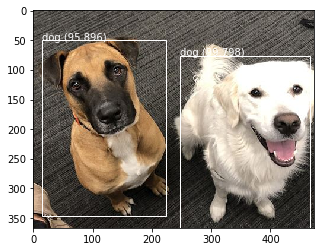

In [25]:
model = load_model('model.h5')
input_width, input_height = 416, 416
photo = 'image3.jpg'
image, image_width, image_height = load_image_pixel(photo, (input_width, input_height))
pred = model.predict(image)
print([a.shape for a in pred])
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
threshold=0.6
boxes=list()

#decoding the predicted values
for i in range(len(pred)):
    boxes+=decode_netout(pred[i][0], anchors[i], threshold, input_height, input_width)
    
#correct sze of the bounding box wrt the original image
correct_yolo_boxes(boxes, image_height, image_width, input_height, input_width)

#remove non maiximum boxes
do_nms(boxes, 0.5)

#list of all the labels 
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


#get the details of the detected objects
v_boxes, v_labels, v_score = get_boxes(boxes, labels, threshold)


#output the results
for i in range(len(v_boxes)):
    print(v_labels[i], v_score[i])

draw_box(photo, v_boxes, v_labels, v_score)